## After wrangling and exploring the data in previous notebooks, this notebook will explore feature engineering and then forecasting the total electricity load using regression, time series forecasting, and ensemble methods.

In [4]:
#import standard packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

#import preprocessing/modeling/error metric packages
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import make_column_transformer
import statsmodels.api as sm
from statsmodels.formula.api import ols
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.model_selection import TimeSeriesSplit
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import TimeSeriesSplit
from sklearn.neighbors import KNeighborsRegressor

In [5]:
combined_avg = pd.read_csv('../raw_data/combined_avg.csv', index_col='time', parse_dates=True)

In [6]:
combined_avg.head(2)

,generation biomass,generation fossil brown coal/lignite,generation fossil gas,generation fossil hard coal,generation fossil oil,generation hydro pumped storage consumption,generation hydro run-of-river and poundage,generation hydro water reservoir,generation nuclear,generation other,...,total load actual,price day ahead,price actual,temp,pressure,humidity,wind_speed,rain_1h,snow_3h,clouds_all
time,,,,,,,,,,,,,,,,,,,,,
2014-12-31 23:00:00+00:00,447.0,329.0,4844.0,4821.0,162.0,863.0,1051.0,1899.0,7096.0,43.0,...,25385.0,50.1,65.41,272.491463,1016.4,82.4,2.0,0.0,0.0,0.0
2015-01-01 00:00:00+00:00,449.0,328.0,5196.0,4755.0,158.0,920.0,1009.0,1658.0,7096.0,43.0,...,24382.0,48.1,64.92,272.512700,1016.2,82.4,2.0,0.0,0.0,0.0


In [7]:
combined_avg.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 35064 entries, 2014-12-31 23:00:00+00:00 to 2018-12-31 22:00:00+00:00
Data columns (total 27 columns):
 #   Column                                       Non-Null Count  Dtype  
---  ------                                       --------------  -----  
 0   generation biomass                           35064 non-null  float64
 1   generation fossil brown coal/lignite         35064 non-null  float64
 2   generation fossil gas                        35064 non-null  float64
 3   generation fossil hard coal                  35064 non-null  float64
 4   generation fossil oil                        35064 non-null  float64
 5   generation hydro pumped storage consumption  35064 non-null  float64
 6   generation hydro run-of-river and poundage   35064 non-null  float64
 7   generation hydro water reservoir             35064 non-null  float64
 8   generation nuclear                           35064 non-null  float64
 9   generation other         

In [8]:
#function to make train-test split for time-indexed data
def ts_train_test(data, target_col_name = 'total load actual', test_size=0.15, stdzd=False, cols_to_scale=None):
    df = data.copy()
    test_index = int(len(df)*(1-test_size)) #get index where test set begins
        
    X_train = df.drop([target_col_name], axis = 1).iloc[:test_index]
    y_train = df[target_col_name].iloc[:test_index]
    X_test = df.drop([target_col_name], axis = 1).iloc[test_index:]
    y_test = df[target_col_name].iloc[test_index:]
    
    # StandardScaler fit seperately on training and test sets
    if stdzd == True:
        scaler = StandardScaler()
        X_train[cols_to_scale] = scaler.fit_transform(X_train[cols_to_scale])
        X_test[cols_to_scale] = scaler.transform(X_test[cols_to_scale])
    
    return X_train, X_test, y_train, y_test        

In [9]:
#Let's engineer some categorical features for use in a regression model like weekend/weekday, winter/summer/spring-fall
df_features = combined_avg.iloc[:,16:].drop(['price day ahead', 'price actual','total load forecast'], axis=1)
features_min = df_features.copy()
df_features.head()

,total load actual,temp,pressure,humidity,wind_speed,rain_1h,snow_3h,clouds_all
time,,,,,,,,
2014-12-31 23:00:00+00:00,25385.0,272.491463,1016.4,82.4,2.0,0.0,0.0,0.0
2015-01-01 00:00:00+00:00,24382.0,272.512700,1016.2,82.4,2.0,0.0,0.0,0.0
2015-01-01 01:00:00+00:00,22734.0,272.099137,1016.8,82.0,2.4,0.0,0.0,0.0
2015-01-01 02:00:00+00:00,21286.0,272.089469,1016.6,82.0,2.4,0.0,0.0,0.0
2015-01-01 03:00:00+00:00,20264.0,272.145900,1016.6,82.0,2.4,0.0,0.0,0.0


In [10]:
#function to calculate basic season label based on month
def season_determination(month):
    if month in [6,7,8,9]: #June-Sept = summer (highest need for cooling in Spain)
        return "summer"
    elif month in [1,2,12]: #Dec, Jan, Feb = winter (highest need for heating)
        return "winter"
    else:
        return "spring/fall" #all other months are spring or fall (similar lower needs for heating/cooling)

In [11]:
day_of_week = {0:'Monday', 1:'Tuesday', 2:'Wednesday', 3: 'Thursday', 4: 'Friday', 5:'Saturday', 6:'Sunday'}
df_features['hour'] = df_features.index.hour
df_features['weekday'] = df_features.index.weekday.map(day_of_week)
df_features['month'] = df_features.index.month #have to create month column because cannot apply() on datetimeindex
df_features['season'] = df_features.month.apply(season_determination)
df_features['nonwork-work_day'] = np.where(df_features.index.weekday > 5, 0, 1)
display(df_features.shape, df_features.head());

(35064, 13)

,total load actual,temp,pressure,humidity,wind_speed,rain_1h,snow_3h,clouds_all,hour,weekday,month,season,nonwork-work_day
time,,,,,,,,,,,,,
2014-12-31 23:00:00+00:00,25385.0,272.491463,1016.4,82.4,2.0,0.0,0.0,0.0,23,Wednesday,12,winter,1
2015-01-01 00:00:00+00:00,24382.0,272.512700,1016.2,82.4,2.0,0.0,0.0,0.0,0,Thursday,1,winter,1
2015-01-01 01:00:00+00:00,22734.0,272.099137,1016.8,82.0,2.4,0.0,0.0,0.0,1,Thursday,1,winter,1
2015-01-01 02:00:00+00:00,21286.0,272.089469,1016.6,82.0,2.4,0.0,0.0,0.0,2,Thursday,1,winter,1
2015-01-01 03:00:00+00:00,20264.0,272.145900,1016.6,82.0,2.4,0.0,0.0,0.0,3,Thursday,1,winter,1


In [12]:
df_features.drop("month", axis=1, inplace=True)

Now that I've used the weekday and month to create the type_of_day and season columns, 
I need to drop the month column because the test set may not contain all months. Now time to one-hot encode the new categorical variables.

In [13]:
#let's split data and then encode the new catergorical variables
X_train, X_test, y_train, y_test = ts_train_test(data = df_features, stdzd=True, 
                                                 cols_to_scale=['temp','pressure','humidity',
                                                                'wind_speed','rain_1h','snow_3h','clouds_all'])
cat_cols = ['hour','weekday','season']
X_train_cat = X_train[['hour','weekday','season']]
X_test_cat = X_test[['hour','weekday','season']]

encoder = OneHotEncoder(sparse=False, drop='first', handle_unknown='ignore')

encoder.fit(X_train_cat)
X_train.drop(columns = cat_cols, inplace=True)
X_train_cat = pd.DataFrame(encoder.transform(X_train_cat), index=X_train.index, 
                           columns = encoder.get_feature_names_out()).astype(int)
X_train = X_train.join(X_train_cat, how ='outer')
#X_train.head()
encoder.fit(X_test_cat)
X_test.drop(columns = cat_cols, inplace=True)
X_test_cat = pd.DataFrame(encoder.transform(X_test_cat), index = X_test.index, 
                           columns = encoder.get_feature_names_out()).astype(int)
X_test = X_test.join(X_test_cat, how ='outer')

display(X_train.head(3), X_test.head(3), X_train.columns)

,temp,pressure,humidity,wind_speed,rain_1h,snow_3h,clouds_all,nonwork-work_day,hour_1,hour_2,...,hour_22,hour_23,weekday_Monday,weekday_Saturday,weekday_Sunday,weekday_Thursday,weekday_Tuesday,weekday_Wednesday,season_summer,season_winter
time,,,,,,,,,,,,,,,,,,,,,
2014-12-31 23:00:00+00:00,-2.327401,0.038628,0.980456,-0.349236,-0.369491,-0.052006,-1.423223,1,0,0,...,0,1,0,0,0,0,0,1,0,1
2015-01-01 00:00:00+00:00,-2.324453,0.015395,0.980456,-0.349236,-0.369491,-0.052006,-1.423223,1,0,0,...,0,0,0,0,0,1,0,0,0,1
2015-01-01 01:00:00+00:00,-2.381861,0.085093,0.953265,-0.064045,-0.369491,-0.052006,-1.423223,1,1,0,...,0,0,0,0,0,1,0,0,0,1


,temp,pressure,humidity,wind_speed,rain_1h,snow_3h,clouds_all,nonwork-work_day,hour_1,hour_2,...,hour_22,hour_23,weekday_Monday,weekday_Saturday,weekday_Sunday,weekday_Thursday,weekday_Tuesday,weekday_Wednesday,season_summer,season_winter
time,,,,,,,,,,,,,,,,,,,,,
2018-05-26 19:00:00+00:00,0.656574,-0.333094,-0.243123,-0.064045,-0.369491,-0.052006,-0.265015,1,0,0,...,0,0,0,1,0,0,0,0,0,0
2018-05-26 20:00:00+00:00,0.456407,-0.309861,0.341476,-0.349236,-0.369491,-0.052006,-0.589313,1,0,0,...,0,0,0,1,0,0,0,0,0,0
2018-05-26 21:00:00+00:00,0.295386,-0.263396,0.626978,-0.919619,-0.369491,-0.052006,-0.728298,1,0,0,...,0,0,0,1,0,0,0,0,0,0


Index(['temp', 'pressure', 'humidity', 'wind_speed', 'rain_1h', 'snow_3h',
       'clouds_all', 'nonwork-work_day', 'hour_1', 'hour_2', 'hour_3',
       'hour_4', 'hour_5', 'hour_6', 'hour_7', 'hour_8', 'hour_9', 'hour_10',
       'hour_11', 'hour_12', 'hour_13', 'hour_14', 'hour_15', 'hour_16',
       'hour_17', 'hour_18', 'hour_19', 'hour_20', 'hour_21', 'hour_22',
       'hour_23', 'weekday_Monday', 'weekday_Saturday', 'weekday_Sunday',
       'weekday_Thursday', 'weekday_Tuesday', 'weekday_Wednesday',
       'season_summer', 'season_winter'],
      dtype='object')

So now X is split into train and test sets, with the first 85% of the data going to training to try to predict approximately the last 7 months out of the four years of data.

# Modeling

First I have written a couple helper functions for calculating error metrics and for creating a TS plot comparing predicted vs actual load for the various forecasting models I will try out.

### Helper functions

In [14]:
#function for calculating and presenting error metrics
#error_dict = {} #dict to hold model name and error metrics for various models that are investigated

def error_metrics(y_true, y_pred, model_name = None):
    
    #function will print RMSE, R2, MAE, MAPE. Assumes y_pred is np array
    
    RMSE = np.sqrt(mean_squared_error(y_true, y_pred))
    R2 = r2_score(y_true, y_pred)
    MAE = mean_absolute_error(y_true, y_pred)
    MAPE = (np.mean(np.abs((y_true - y_pred) / y_true)) * 100)

    print('\nError metrics for model: {}'.format(model_name))
    print("RMSE: %.2f" % RMSE)
    print('Variance/R^2: %.2f' % R2)
    print('MAE: %.2f' % MAE)
    print('Mean Absolute Percentage Error: %.2f %%' % MAPE)

In [15]:
#fnc for plotting time series of predicted vs true values
def plot_ts_pred_true(y_pred, y_true, model_name=None):
    fig, ax = plt.subplots(figsize =(15,10))
    ax.plot(y_true.index, y_pred, linestyle='-', linewidth=1, label = 'Model Forecasted Total Load', color = 'blue',alpha = 0.4)
    y_true.plot(linestyle='-', linewidth=1, label = 'Actual Total Load', color = 'red',alpha = 0.4)

    plt.ylabel('Load/Demand (MW)')
    plt.xlabel("Time")
    plt.title("Observed vs model-predicted total load (MWH) using {}".format(model_name))
    plt.legend()
    plt.show()

First I will try out a simple linear regression using the weather and categorical variables:
### Linear Regression

In [16]:
linreg = LinearRegression()
linreg.fit(X_train, y_train)

LinearRegression()

In [17]:
error_metrics(linreg.predict(X_train), y_train, model_name = 'simple linear regression (train set)')


Error metrics for model: simple linear regression (train set)
RMSE: 2860.94
Variance/R^2: 0.36
MAE: 2202.74
Mean Absolute Percentage Error: 7.64 %


In [18]:
error_metrics(linreg.predict(X_test), y_test, model_name = 'simple linear regression (test set)')


Error metrics for model: simple linear regression (test set)
RMSE: 2850.02
Variance/R^2: 0.36
MAE: 2174.66
Mean Absolute Percentage Error: 7.55 %


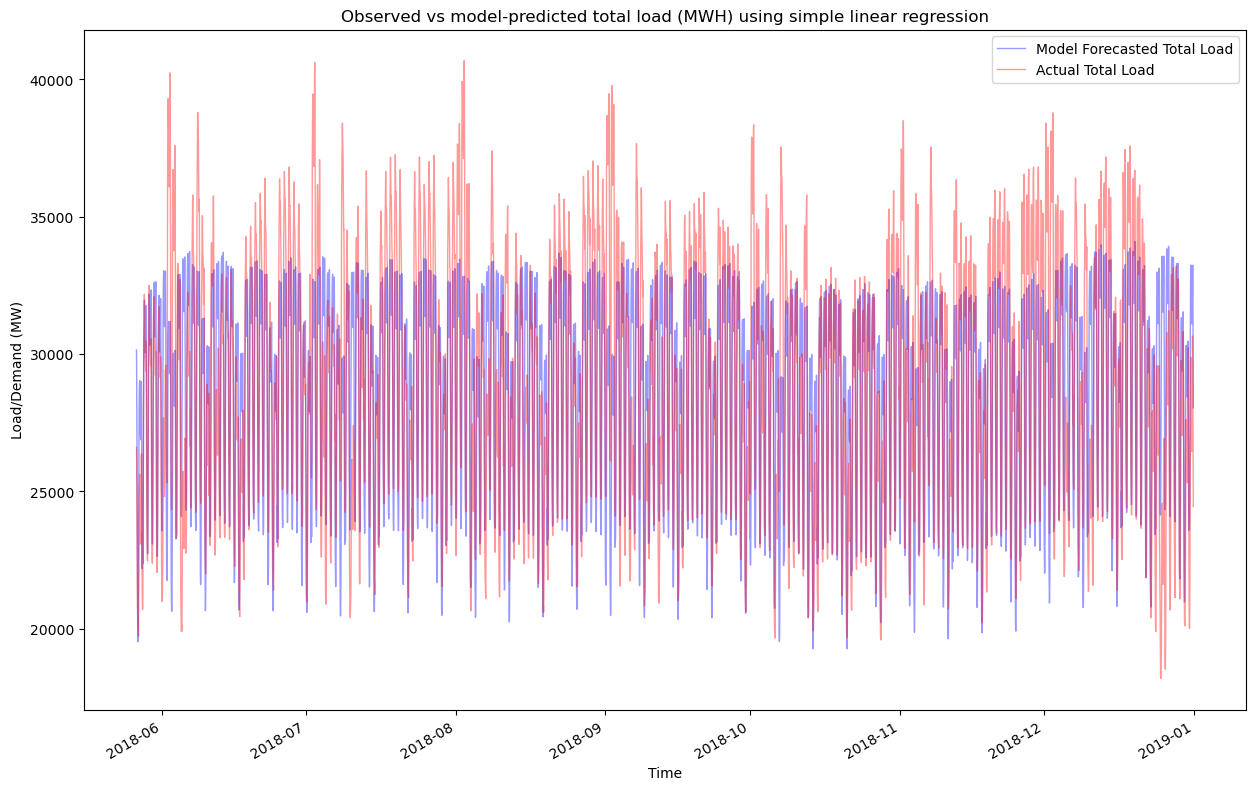

In [19]:
plot_ts_pred_true(y_pred = linreg.predict(X_test), y_true = y_test, model_name = "simple linear regression")

In [20]:
#let's try using a df with reduced feature space, by eliminating some possibly extraneous variables:

X_train_red = X_train.drop(['hour_1', 'hour_2', 'hour_3', 'hour_4', 'hour_5', 'hour_6', 'hour_7', 'hour_8', 'hour_9',
       'hour_10', 'hour_11', 'hour_12', 'hour_13', 'hour_14', 'hour_15', 'hour_16', 'hour_17', 'hour_18', 
       'hour_19', 'hour_20', 'hour_21', 'hour_22', 'hour_23', 'weekday_Monday', 'weekday_Saturday', 'weekday_Sunday', 
       'weekday_Thursday', 'weekday_Tuesday','weekday_Wednesday',], axis=1)
X_test_red = X_test.drop(['hour_1', 'hour_2', 'hour_3', 'hour_4', 'hour_5', 'hour_6', 'hour_7', 'hour_8', 'hour_9',
       'hour_10', 'hour_11', 'hour_12', 'hour_13', 'hour_14', 'hour_15', 'hour_16', 'hour_17', 'hour_18', 
       'hour_19', 'hour_20', 'hour_21', 'hour_22', 'hour_23', 'weekday_Monday', 'weekday_Saturday', 'weekday_Sunday', 
       'weekday_Thursday', 'weekday_Tuesday','weekday_Wednesday',], axis=1)

### Linear regression on reduced feature space

In [21]:
linreg_red = LinearRegression()
linreg_red.fit(X_train_red, y_train)

LinearRegression()

In [22]:
error_metrics(y_train, linreg_red.predict(X_train_red), model_name = 'simple linear regression on reduced features (train set)')


Error metrics for model: simple linear regression on reduced features (train set)
RMSE: 3977.88
Variance/R^2: 0.24
MAE: 3275.40
Mean Absolute Percentage Error: 11.77 %


We can see that the simple linear regression model using the larger set of features predicts the weekly seasonality fairly well but is often over or underpredicting the max daily load. The model using the reduced feature space performs worse. Let's also check out a baseline model that just predicts the same as the value for the same date/time from the previous year:
### Simple Year-over-Year Baseline 

In [23]:
# errors metrics for a baseline forecast (that simply repeats the values from the previous year)
#error_metrics(y_true, y_pred, model_name = None)
_ = error_metrics(y_test, df_features.loc[X_test.index.shift(-8760, freq='H'), 'total load actual'],
              model_name='Baseline forecast (repeat of previous year)')



Error metrics for model: Baseline forecast (repeat of previous year)
RMSE: 3100.81
Variance/R^2: 0.54
MAE: 2249.00
Mean Absolute Percentage Error: nan %


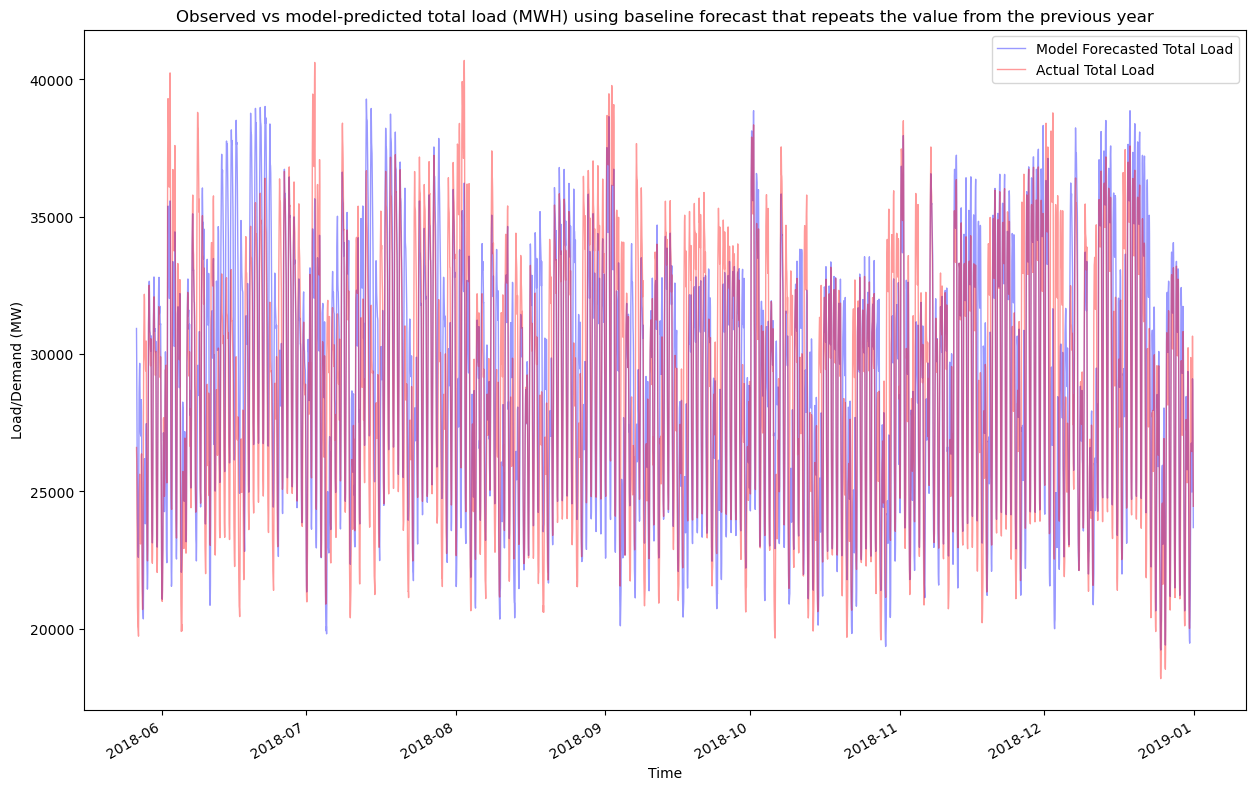

In [24]:
#def plot_ts_pred_true(y_pred, y_true, model_name=None):
plot_ts_pred_true(y_pred = df_features.loc[X_test.index.shift(-8760, freq='H'), 'total load actual'], y_true = y_test, 
                  model_name = "baseline forecast that repeats the value from the previous year")

Visually we can can see that the baseline model that just uses the value from the same time from the previous year does a decent job, but misses the max pretty badly sometimes. Which makes sense, because on average things are similar year to year but the peak demand will definitely be much higher or much lower on certain days. Let's try out a couple more regression models before trying some time series forecasting:

### Random Forest

In [25]:
#set up a parameter grid of different values for GridSearchCV of number of trees and max depth
n_est = [int(n) for n in np.logspace(start=1, stop=2.5, num=12)]
max_depth = list(range(1,6))

param_grid = {
        'n_estimators': n_est,
        'max_depth': max_depth
}
param_grid

{'n_estimators': [10, 13, 18, 25, 35, 48, 65, 90, 123, 168, 231, 316],
 'max_depth': [1, 2, 3, 4, 5]}

In [26]:
#create instance of base model
rfreg = RandomForestRegressor()

#create TS splits for cross val (instead of random splits, this uses progressively larger sets starting from beginning)
tss = TimeSeriesSplit(n_splits=5)

#create instance of RandomSearchCV
rf_cv = RandomizedSearchCV(rfreg, param_distributions=param_grid, cv=tss, random_state=47)

# Fit the random search model using reduced feature space X set
rf_cv.fit(X_train_red, y_train)

rf_cv.best_params_


{'n_estimators': 65, 'max_depth': 5}

The R^2 score:

In [27]:
rf_cv.score(X_train_red, y_train)

0.28045710486213626

In [28]:
rf_cv.score(X_test_red, y_test)

0.26043154423934367

In [29]:
#RF error metrics
_ = error_metrics(y_train, rf_cv.predict(X_train_red),  
                  model_name = 'Random Forest Regression on reduced feature space tuned with Random Search CV (train set)')


Error metrics for model: Random Forest Regression on reduced feature space tuned with Random Search CV (train set)
RMSE: 3877.11
Variance/R^2: 0.28
MAE: 3179.88
Mean Absolute Percentage Error: 11.46 %


Let's also try Random Forest on the full feature space dataset:

In [30]:
#create instance of base model
rfreg = RandomForestRegressor()

#create TS splits for cross val (instead of random splits, this uses progressively larger sets starting from beginning)
tss = TimeSeriesSplit(n_splits=5)

#create instance of RandomSearchCV
rf_cv_full = RandomizedSearchCV(rfreg, param_distributions=param_grid, cv=tss, random_state=47)

# Fit the random search model using reduced feature space X set
rf_cv_full.fit(X_train, y_train)

rf_cv_full.best_params_

{'n_estimators': 65, 'max_depth': 5}

In [31]:
rf_cv_full.score(X_train, y_train)

0.373844200573482

In [32]:
rf_cv_full.score(X_test, y_test)

0.3825372564133235

In [33]:
_ = error_metrics(y_train, rf_cv_full.predict(X_train), 
                  model_name = 'Random Forest Regression tuned with Random Search CV (train set)')


Error metrics for model: Random Forest Regression tuned with Random Search CV (train set)
RMSE: 3616.77
Variance/R^2: 0.37
MAE: 2849.09
Mean Absolute Percentage Error: 10.19 %


In [34]:
_ = error_metrics(y_test, rf_cv_full.predict(X_test), 
                  model_name = 'Random Forest Regression tuned with Random Search CV (test set)')


Error metrics for model: Random Forest Regression tuned with Random Search CV (test set)
RMSE: 3607.46
Variance/R^2: 0.38
MAE: 2837.00
Mean Absolute Percentage Error: 9.88 %


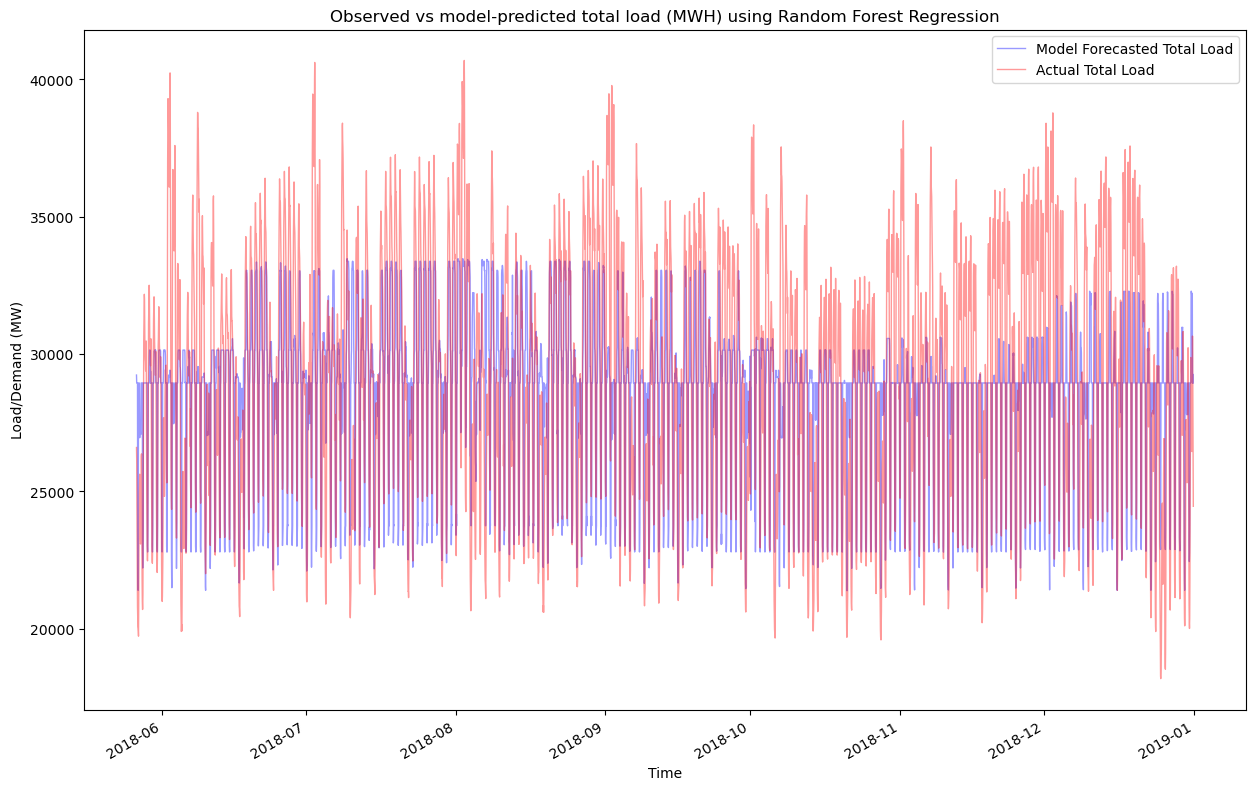

In [35]:
plot_ts_pred_true(y_pred = rf_cv_full.predict(X_test), y_true = y_test, model_name = "Random Forest Regression")

So Random Forest performs slightly worse that linear regression. It seems to consistently underpredict the true values. Let's also try KNeighbors Regression:

In [36]:
#set up a parameter grid for KNeighbors Random CV search:

n_neigh = [int(n) for n in np.logspace(start=0.5, stop=1.8, num=10)]
weights = ['uniform', 'distance']
leaf_size = [int(n) for n in np.logspace(start=0.5, stop=1.9, num=6)]

kn_param_grid = {
        'n_neighbors': n_neigh,
        'weights': weights,
        'leaf_size':leaf_size
}
kn_param_grid

{'n_neighbors': [3, 4, 6, 8, 11, 16, 23, 32, 45, 63],
 'weights': ['uniform', 'distance'],
 'leaf_size': [3, 6, 11, 21, 41, 79]}

In [37]:
#create instance of base model
kn = KNeighborsRegressor()

#create TS splits for cross val (instead of random splits, this uses progressively larger sets starting from beginning)
tss = TimeSeriesSplit(n_splits=5)

#create instance of RandomSearchCV
kn_cv = RandomizedSearchCV(kn, param_distributions = kn_param_grid, cv=tss, random_state=47)

# Fit the random search model using reduced feature space X set
kn_cv.fit(X_train, y_train)

kn_cv.best_params_


{'weights': 'distance', 'n_neighbors': 11, 'leaf_size': 41}

In [38]:
kn_cv.score(X_train, y_train)

0.9999999999999822

In [39]:
kn_cv.score(X_test, y_test)

0.5717077508212619

In [40]:
_ = error_metrics(y_test, kn_cv.predict(X_test), 
                  model_name = 'KNeighbors Regression tuned with Random Search CV (test set)')


Error metrics for model: KNeighbors Regression tuned with Random Search CV (test set)
RMSE: 3004.46
Variance/R^2: 0.57
MAE: 2187.55
Mean Absolute Percentage Error: 7.44 %


As expected, this model wildly overfits the training data and performs fairly poorly on the test data. Now to try some time series forecasting.

# Time Series Forecasting

In [41]:
#%conda install -c conda-forge sktime-all-extras
#import packages
import sktime
from statsmodels.graphics import tsaplots
from statsmodels.tsa.seasonal import STL
from statsmodels.tsa.stattools import adfuller

In [42]:
# a simple time series DF for use in models without the exogenous variables
ts_load = pd.DataFrame(combined_avg["total load actual"], columns=['total load actual'])
ts_load.head()

,total load actual
time,
2014-12-31 23:00:00+00:00,25385.0
2015-01-01 00:00:00+00:00,24382.0
2015-01-01 01:00:00+00:00,22734.0
2015-01-01 02:00:00+00:00,21286.0
2015-01-01 03:00:00+00:00,20264.0


With the univariate TS dataframe, I will use the statsmodels Augmented Dickey-Fuller test to test for stationarity. The null hypothesis is that the series is not stationary (no trend, constant variance over time, constant autocorrelation structure over time) and the alternative hypothesis is that the time series is stationary. If the p-value is less than 0.05, we reject the null hypothesis and conclude the series is stationary. 

In [43]:
#let's use the simple ts df to test for stationarity, as many ts models assume stationarity
adf_result = adfuller(ts_load)
#print test statisitc
print("t-stat", adf_result[0])
# Print p-value
print("p-value", adf_result[1])
# Print number of lags used
print("#lags used", adf_result[2])
# Print critical values
print("critical values", adf_result[4]) 

t-stat -21.420315756960576
p-value 0.0
#lags used 52
critical values {'1%': -3.43053679213716, '5%': -2.8616225575095284, '10%': -2.566813942767471}


With a p-value of zero, we can say that the data are stationary. Even though we know the data have seasonality, perhaps the p-value is so low because there is very little trend. But let's have a look at the decomposition of the trend, seasonality, and residuals. Let's start with the largest seasonal component, the yearly seasonality:

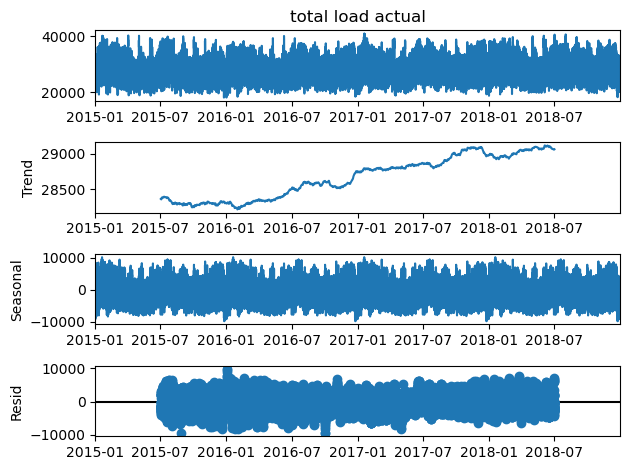

In [44]:
#seasonal decomposition
decomp = sm.tsa.seasonal_decompose(ts_load['total load actual'], period=24*365) #the yearly seasonal component
#the main seasonal component is the shift from winter to spring to summer to fall and back to winter an so on...
# so the period is 24*365

_ = decomp.plot() #plot the seasonal components

So the seasonal decomposition actually does show a trend, but it is so small as to almost be negligible (an increase of about 900 MWH out of about 30000 over 4 years). The seasonal component plot clearly shows the peaks during summer and winter and relative lows in spring and fall.

In [45]:
# Differencing the data once
#decomp_diff1 = sm.tsa.seasonal_decompose(ts_load['total load actual'].diff().dropna(), period=24*365) 
#_ = decomp_diff1.plot()

In [46]:
#Decomposition on the data with 24-hour differencing, 24 being the period of the shortest seasonality in the dataset
#decomp_diff24 = sm.tsa.seasonal_decompose(ts_load['total load actual'].diff(24).dropna(), period=24*365) 
#_ = decomp_diff24.plot()

Now I will use the FourierFeatures class from sktime to create Fourier terms for the multiple seasonalities so that we can use the SARIMAX forecasting model (which only handles a single seasonality). SARIMAX tends to handle short seasonality better than long seasonality, so I can either create Fourier terms for all the seasonalities, or create them only for the yearly/seasonal and weekly seasonalities and let the model handle the daily seasonality.

In [47]:
from sktime.transformations.series.fourier import FourierFeatures
''' example from sktime documentation to help understand implementation of FF
from sktime.datasets import load_airline
y_toy = load_airline()
transformer = FourierFeatures(sp_list=[12], fourier_terms_list=[4])
y_hat = transformer.fit_transform(y_toy)
display(y_toy.head(), y_hat.head())
#https://robjhyndman.com/hyndsight/forecasting-weekly-data/ #shows how to find best value of k
'''
ff_transformer = FourierFeatures(sp_list=[24,24*7,24*365.25], fourier_terms_list=[5,5,5]) #k=5 common value in energy forecasting
load_ff = ff_transformer.fit_transform(ts_load['total load actual'])
display(load_ff.head())

,total load actual,sin_24_1,cos_24_1,sin_24_2,cos_24_2,sin_24_3,cos_24_3,sin_24_4,cos_24_4,sin_24_5,...,sin_8766.0_1,cos_8766.0_1,sin_8766.0_2,cos_8766.0_2,sin_8766.0_3,cos_8766.0_3,sin_8766.0_4,cos_8766.0_4,sin_8766.0_5,cos_8766.0_5
time,,,,,,,,,,,,,,,,,,,,,
2014-12-31 23:00:00+00:00,25385.0,0.000000,1.0,0.000000,1.0,0.000000,1.0,0.000000,1.0,0.000000,...,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000
2015-01-01 00:00:00+00:00,24382.0,0.000017,1.0,0.000033,1.0,0.000050,1.0,0.000067,1.0,-0.000405,...,0.424729,0.905321,0.769031,0.639211,0.967711,0.252063,0.983147,-0.182818,0.812416,-0.583078
2015-01-01 01:00:00+00:00,22734.0,0.000033,1.0,0.000067,1.0,0.000100,1.0,0.000134,1.0,-0.000809,...,0.769031,0.639211,0.983147,-0.182818,0.487848,-0.872929,-0.359473,-0.933155,-0.947404,-0.320041
2015-01-01 02:00:00+00:00,21286.0,0.000050,1.0,0.000100,1.0,-0.000338,1.0,0.000201,1.0,0.000739,...,0.967711,0.252063,0.487848,-0.872929,-0.721774,-0.692129,-0.851713,0.524009,0.292409,0.956293
2015-01-01 03:00:00+00:00,20264.0,0.000067,1.0,0.000134,1.0,0.000201,1.0,0.000268,1.0,-0.001618,...,0.983147,-0.182818,-0.359473,-0.933155,-0.851713,0.524009,0.670889,0.741558,0.606416,-0.795148


Now that I have the seasonalities represented as Fourier terms, I can use the SARIMAX model with autoARIMA for tuning to find the best values of pdq.

In [48]:
#merge the new Fourier df with the features_min df (that excludes engineered features used in regression, 
#and just reverts back to only weather variables)
ff_combined = features_min.drop(['total load actual'], axis=1).merge(load_ff, left_index=True, right_index=True)
ff_combined.head()

,temp,pressure,humidity,wind_speed,rain_1h,snow_3h,clouds_all,total load actual,sin_24_1,cos_24_1,...,sin_8766.0_1,cos_8766.0_1,sin_8766.0_2,cos_8766.0_2,sin_8766.0_3,cos_8766.0_3,sin_8766.0_4,cos_8766.0_4,sin_8766.0_5,cos_8766.0_5
time,,,,,,,,,,,,,,,,,,,,,
2014-12-31 23:00:00+00:00,272.491463,1016.4,82.4,2.0,0.0,0.0,0.0,25385.0,0.000000,1.0,...,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000
2015-01-01 00:00:00+00:00,272.512700,1016.2,82.4,2.0,0.0,0.0,0.0,24382.0,0.000017,1.0,...,0.424729,0.905321,0.769031,0.639211,0.967711,0.252063,0.983147,-0.182818,0.812416,-0.583078
2015-01-01 01:00:00+00:00,272.099137,1016.8,82.0,2.4,0.0,0.0,0.0,22734.0,0.000033,1.0,...,0.769031,0.639211,0.983147,-0.182818,0.487848,-0.872929,-0.359473,-0.933155,-0.947404,-0.320041
2015-01-01 02:00:00+00:00,272.089469,1016.6,82.0,2.4,0.0,0.0,0.0,21286.0,0.000050,1.0,...,0.967711,0.252063,0.487848,-0.872929,-0.721774,-0.692129,-0.851713,0.524009,0.292409,0.956293
2015-01-01 03:00:00+00:00,272.145900,1016.6,82.0,2.4,0.0,0.0,0.0,20264.0,0.000067,1.0,...,0.983147,-0.182818,-0.359473,-0.933155,-0.851713,0.524009,0.670889,0.741558,0.606416,-0.795148


In [49]:
#then create a train-test split with new Fourier terms:
#ts_train_test(data, target_col_name = 'total load actual', test_size=0.15, stdzd=False, cols_to_scale=None)
X_train_ff, X_test_ff, y_train, y_test = ts_train_test(data = ff_combined, stdzd=True, 
                                                 cols_to_scale=['temp','pressure','humidity',
                                                                'wind_speed','rain_1h','snow_3h','clouds_all'])
display(X_train_ff.head(3), X_test_ff.head(3), X_train_ff.columns)

,temp,pressure,humidity,wind_speed,rain_1h,snow_3h,clouds_all,sin_24_1,cos_24_1,sin_24_2,...,sin_8766.0_1,cos_8766.0_1,sin_8766.0_2,cos_8766.0_2,sin_8766.0_3,cos_8766.0_3,sin_8766.0_4,cos_8766.0_4,sin_8766.0_5,cos_8766.0_5
time,,,,,,,,,,,,,,,,,,,,,
2014-12-31 23:00:00+00:00,-2.327401,0.038628,0.980456,-0.349236,-0.369491,-0.052006,-1.423223,0.000000,1.0,0.000000,...,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000
2015-01-01 00:00:00+00:00,-2.324453,0.015395,0.980456,-0.349236,-0.369491,-0.052006,-1.423223,0.000017,1.0,0.000033,...,0.424729,0.905321,0.769031,0.639211,0.967711,0.252063,0.983147,-0.182818,0.812416,-0.583078
2015-01-01 01:00:00+00:00,-2.381861,0.085093,0.953265,-0.064045,-0.369491,-0.052006,-1.423223,0.000033,1.0,0.000067,...,0.769031,0.639211,0.983147,-0.182818,0.487848,-0.872929,-0.359473,-0.933155,-0.947404,-0.320041


,temp,pressure,humidity,wind_speed,rain_1h,snow_3h,clouds_all,sin_24_1,cos_24_1,sin_24_2,...,sin_8766.0_1,cos_8766.0_1,sin_8766.0_2,cos_8766.0_2,sin_8766.0_3,cos_8766.0_3,sin_8766.0_4,cos_8766.0_4,sin_8766.0_5,cos_8766.0_5
time,,,,,,,,,,,,,,,,,,,,,
2018-05-26 19:00:00+00:00,0.656574,-0.333094,-0.243123,-0.064045,-0.369491,-0.052006,-0.265015,0.161440,-0.986883,-0.318644,...,-0.990955,0.134195,-0.265962,-0.963983,0.913322,-0.407238,0.512767,0.858528,-0.772117,0.635480
2018-05-26 20:00:00+00:00,0.456407,-0.309861,0.341476,-0.349236,-0.369491,-0.052006,-0.589313,-0.239367,0.970929,-0.464817,...,-0.840148,0.542357,-0.911321,-0.411698,-0.132905,-0.991129,0.750377,-0.661010,0.957953,0.286926
2018-05-26 21:00:00+00:00,0.295386,-0.263396,0.626978,-0.919619,-0.369491,-0.052006,-0.728298,-0.924486,0.381216,-0.704857,...,-0.530268,0.847830,-0.899155,0.437631,-0.995923,-0.090207,-0.786996,-0.616958,-0.354737,-0.934966


Index(['temp', 'pressure', 'humidity', 'wind_speed', 'rain_1h', 'snow_3h',
       'clouds_all', 'sin_24_1', 'cos_24_1', 'sin_24_2', 'cos_24_2',
       'sin_24_3', 'cos_24_3', 'sin_24_4', 'cos_24_4', 'sin_24_5', 'cos_24_5',
       'sin_168_1', 'cos_168_1', 'sin_168_2', 'cos_168_2', 'sin_168_3',
       'cos_168_3', 'sin_168_4', 'cos_168_4', 'sin_168_5', 'cos_168_5',
       'sin_8766.0_1', 'cos_8766.0_1', 'sin_8766.0_2', 'cos_8766.0_2',
       'sin_8766.0_3', 'cos_8766.0_3', 'sin_8766.0_4', 'cos_8766.0_4',
       'sin_8766.0_5', 'cos_8766.0_5'],
      dtype='object')

I will try plotting the auto and partial autocorrelations to try to determine the q (moving average- MA) and p (auto regression -AR) terms of the ARIMA model. The daily trend is readily apparent in the ACF plot:

C:\Users\ehard\anaconda3\envs\Cap2New\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


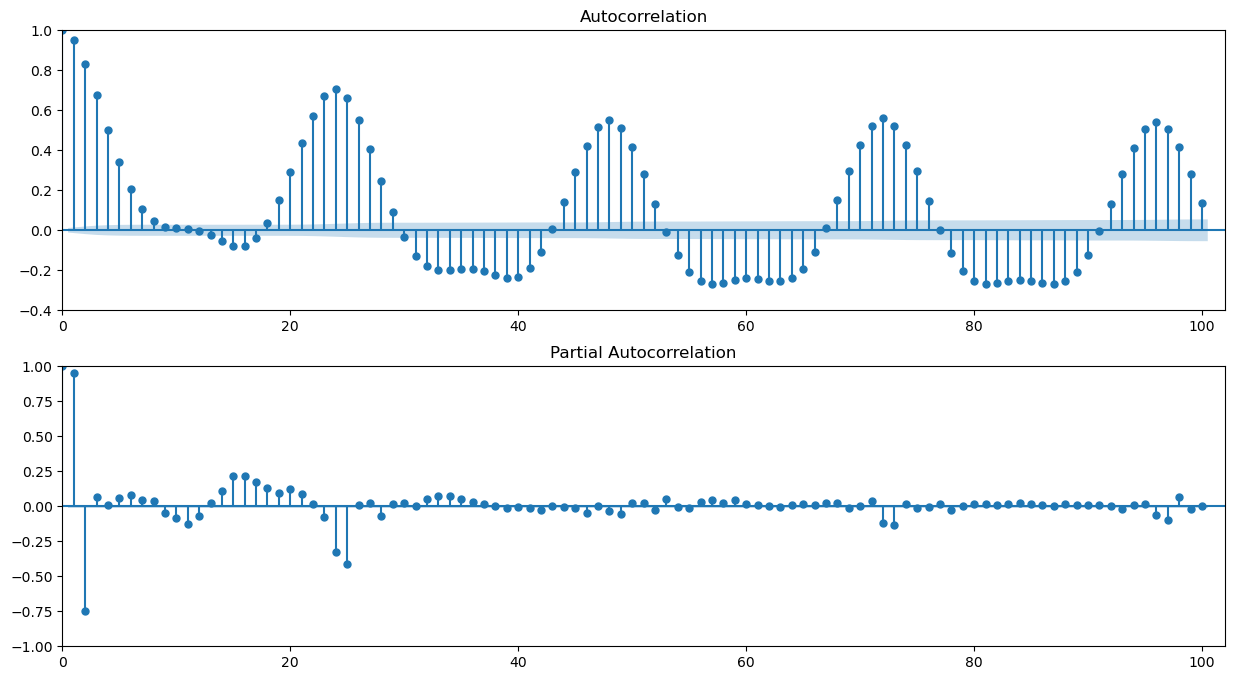

In [50]:
fig,ax = plt.subplots(2,1,figsize=(15,8))
fig = sm.graphics.tsa.plot_acf(y_train, lags=100, ax=ax[0])
fig = sm.graphics.tsa.plot_pacf(y_train, lags=100, ax=ax[1])
ax[0].set_xlim(0, 102)
ax[0].set_ylim(-0.4,1)
ax[1].set_xlim(0, 102)
plt.show()

Next I will apply first and 24-hour seasonal differences to see how they affect the stationarity of the data:

In [51]:
ytrain_seas = y_train.diff(24)
ytrain_diff = y_train.diff()
ytrain_both = ytrain_seas.diff()

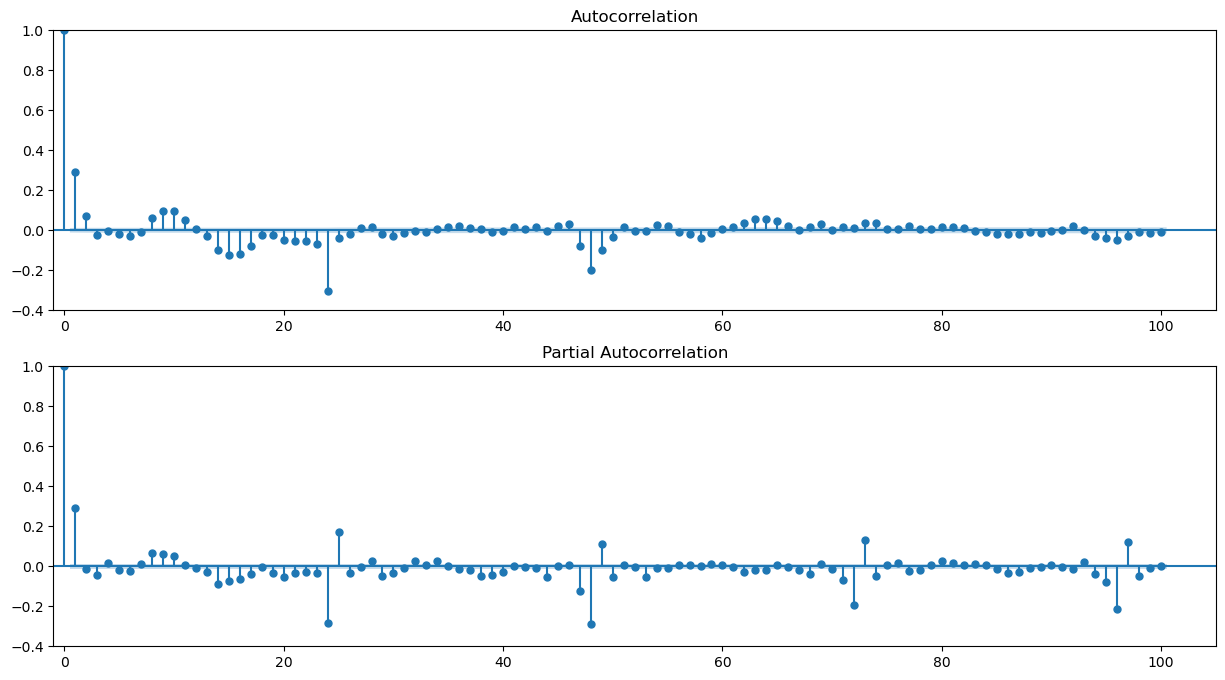

In [52]:
fig,ax = plt.subplots(2,1,figsize=(15,8))
fig = sm.graphics.tsa.plot_acf(ytrain_both[25:], lags=100, ax=ax[0])
fig = sm.graphics.tsa.plot_pacf(ytrain_both[25:], lags=100, ax=ax[1])
ax[0].set_xlim(-1, 105)
ax[0].set_ylim(-0.4,1)
ax[1].set_xlim(-1, 105)
ax[1].set_ylim(-0.4,1)
plt.show()

The PACF plot shows positive spikes at 1, 25, etc, indicating the daily trend is still apparent, and negative spikes at 24, 48, 72, etc...
So given the above information from the first-differenced, 24-hr differenced ACF and PACF, a first pass at SARIMA parameters might be: (1,0,1)x(1,0,1,24) since d=0 for no trend.

In [53]:
#%conda install -c conda-forge pmdarima
#%conda install -c conda-forge statsforecast
#import pmdarima as pm
#from sktime.forecasting.arima import AutoARIMA #https://alkaline-ml.com/pmdarima/tips_and_tricks.html
#https://medium.com/@josemarcialportilla/using-python-and-auto-arima-to-forecast-seasonal-time-series-90877adff03c

#stepwise_fit = pm.auto_arima(y_train, X=X_train_ff,
                             #start_p=1, d=0, start_q=1,                              
                             #max_p=2, max_d=0, max_q=2,                       
                             #start_P=1, D=0, start_Q=1,                             
                             #max_P=2, max_D=0, max_Q=2,
                             #m=24, seasonal=True,
                             #information_criterion='aic',
                             #stepwise=True,
                             #error_action='ignore',
                             #trace=True)
#from sktime.forecasting.statsforecast import StatsForecastAutoARIMA
#stepwise_fit = StatsForecastAutoARIMA(start_p=1, start_q=1,
 #                                    max_p=3, max_q=3,
  #                                   start_P=1, D=1, start_Q=1,
   #                                  max_P=3, max_D=2, max_Q=3,
    #                                 sp=24, seasonal=True,
     #                                stationary=True,
      #                               information_criterion='aic',
       #                              stepwise=True, trend=False)
                                     

In [54]:
#stepwise_fit.fit(y_train)
#print(stepwise_fit.get_test_params())

In [55]:
#let's try the sm SARIMAX
#from sktime.forecasting.sarimax import SARIMAX
#sarimax_model = SARIMAX(order=(1,0,1), seasonal_order=(1,0,1,24), enforce_stationarity=False, freq='H')

#sar_mod = sm.tsa.statespace.SARIMAX(ytrain_both, order=(1,0,1), seasonal_order=(1,0,1,24), freq='H')

In [56]:
#sar_results = sar_mod.fit(method = 'powell')
#sar_results.summary()

In [57]:
#sarimax_results = sarimax_model.fit(y_train, X_train_ff)

In [58]:
#print(sarimax_results.summary())

In [59]:
'''
from sktime.forecasting.base import ForecastingHorizon
from sktime.utils.plotting import plot_series

fh = ForecastingHorizon(168, is_relative=True, freq='H')
test = X_test_ff[:168]

y_pred = sarimax_results.predict(X=test, fh=fh)
'''

"\nfrom sktime.forecasting.base import ForecastingHorizon\nfrom sktime.utils.plotting import plot_series\n\nfh = ForecastingHorizon(168, is_relative=True, freq='H')\ntest = X_test_ff[:168]\n\ny_pred = sarimax_results.predict(X=test, fh=fh)\n"

In [60]:
#plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"]);

## FB Prophet

Unlike SARIMAX, Prophet handles multi-seasonality well so I do not need to pass in the Fourier terms separately. The exogenous variables would return to just the weather variables. Prophet needs the time data in a specific format (not as index). And the target variable column needs to be named 'y'. You can add seasonalities, regressors, and even holidays in a given country.

In [61]:
#%conda install -c conda-forge prophet
from prophet import Prophet

#for now, let's try with just the basic weather vars as our regressors
#prophet_min = combined_avg.iloc[:,16:].drop(['price day ahead', 'price actual','total load forecast'], axis=1)
#features_min = df_features.copy()
prophet_min = features_min.copy()
prophet_min.head(3)

,total load actual,temp,pressure,humidity,wind_speed,rain_1h,snow_3h,clouds_all
time,,,,,,,,
2014-12-31 23:00:00+00:00,25385.0,272.491463,1016.4,82.4,2.0,0.0,0.0,0.0
2015-01-01 00:00:00+00:00,24382.0,272.512700,1016.2,82.4,2.0,0.0,0.0,0.0
2015-01-01 01:00:00+00:00,22734.0,272.099137,1016.8,82.0,2.4,0.0,0.0,0.0


In [62]:
def prophetize(df):
    df_prophetized = df.reset_index().rename(columns={'total load actual':'y', 'time':'ds'})
    df_prophetized['ds'] = df_prophetized['ds'].dt.tz_localize(None)
    return df_prophetized

In [63]:
prophet_df = prophetize(prophet_min)
prophet_df.head(3)

,ds,y,temp,pressure,humidity,wind_speed,rain_1h,snow_3h,clouds_all
0,2014-12-31 23:00:00,25385.0,272.491463,1016.4,82.4,2.0,0.0,0.0,0.0
1,2015-01-01 00:00:00,24382.0,272.512700,1016.2,82.4,2.0,0.0,0.0,0.0
2,2015-01-01 01:00:00,22734.0,272.099137,1016.8,82.0,2.4,0.0,0.0,0.0


In [64]:
#perform train-test split and Scaling
X_trainP, X_testP, y_trainP, y_testP = ts_train_test(data = prophet_df, target_col_name = 'y', stdzd=True, 
                                                 cols_to_scale=['temp','pressure','humidity',
                                                                'wind_speed','rain_1h','snow_3h','clouds_all'])

In [65]:
trainP = pd.merge(X_trainP, y_trainP, left_index=True, right_index=True)
testP = pd.merge(X_testP, y_testP, left_index=True, right_index=True)
trainP.head()

,ds,temp,pressure,humidity,wind_speed,rain_1h,snow_3h,clouds_all,y
0,2014-12-31 23:00:00,-2.327401,0.038628,0.980456,-0.349236,-0.369491,-0.052006,-1.423223,25385.0
1,2015-01-01 00:00:00,-2.324453,0.015395,0.980456,-0.349236,-0.369491,-0.052006,-1.423223,24382.0
2,2015-01-01 01:00:00,-2.381861,0.085093,0.953265,-0.064045,-0.369491,-0.052006,-1.423223,22734.0
3,2015-01-01 02:00:00,-2.383203,0.061861,0.953265,-0.064045,-0.369491,-0.052006,-1.423223,21286.0
4,2015-01-01 03:00:00,-2.375370,0.061861,0.953265,-0.064045,-0.369491,-0.052006,-1.423223,20264.0


In [66]:
proph_mod = Prophet(interval_width = 0.95, 
                yearly_seasonality='auto',
                weekly_seasonality='auto',
                daily_seasonality='auto',
                seasonality_mode='additive')

In [67]:
#add the regressor variables:
proph_mod.add_regressor('temp', standardize=False)
proph_mod.add_regressor('pressure', standardize=False)
proph_mod.add_regressor('humidity', standardize=False)
proph_mod.add_regressor('wind_speed', standardize=False)
proph_mod.add_regressor('rain_1h', standardize=False)
proph_mod.add_regressor('snow_3h', standardize=False)
proph_mod.add_regressor('clouds_all', standardize=False)

In [68]:
proph_mod.fit(trainP)

15:54:24 - cmdstanpy - INFO - Chain [1] start processing
15:54:46 - cmdstanpy - INFO - Chain [1] done processing


In [69]:
#dataframe with dt values to predict on (pred on train and test set)
future_dates = proph_mod.make_future_dataframe(periods=len(testP), freq='H', include_history=True)
# add regressors 
future_dates = pd.merge(future_dates, (trainP.append(testP)).drop('y', axis=1), on = 'ds')
future_dates.tail()

C:\Users\ehard\AppData\Local\Temp\ipykernel_19668\3197948338.py:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  future_dates = pd.merge(future_dates, (trainP.append(testP)).drop('y', axis=1), on = 'ds')


,ds,temp,pressure,humidity,wind_speed,rain_1h,snow_3h,clouds_all
35059,2018-12-31 18:00:00,-0.664638,1.525514,0.382262,-0.777023,-0.369491,-0.052006,-1.423223
35060,2018-12-31 19:00:00,-0.966692,1.618444,0.001593,-0.491832,-0.369491,-0.052006,-1.423223
35061,2018-12-31 20:00:00,-1.167137,1.595212,0.232713,0.078551,-0.369491,-0.052006,-1.423223
35062,2018-12-31 21:00:00,-1.324272,1.641677,0.137546,0.221147,-0.369491,-0.052006,-1.423223
35063,2018-12-31 22:00:00,-1.451979,1.641677,0.980456,0.078551,-0.369491,-0.052006,-1.423223


In [70]:
forecast = proph_mod.predict(future_dates)
forecast[['ds','yhat','yhat_lower','yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
35059,2018-12-31 18:00:00,31654.075531,25679.170022,37163.876167
35060,2018-12-31 19:00:00,31901.885995,25932.590117,37502.434542
35061,2018-12-31 20:00:00,30994.467211,25422.702583,36237.197517
35062,2018-12-31 21:00:00,29202.861688,22781.317565,35024.808148
35063,2018-12-31 22:00:00,27067.555414,21671.649851,32541.257328


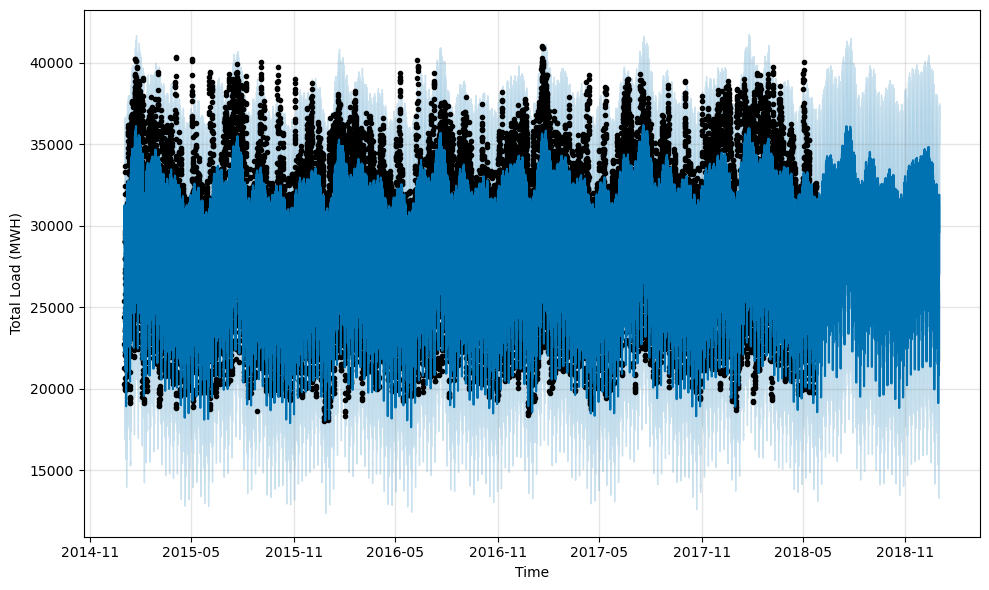

In [71]:
_ = proph_mod.plot(forecast, uncertainty = True, xlabel = 'Time', ylabel = 'Total Load (MWH)')

It appears that the model does a reasonably good job overall, and predicts the lows quite well, while coming in a bit low on most of the peak loads.

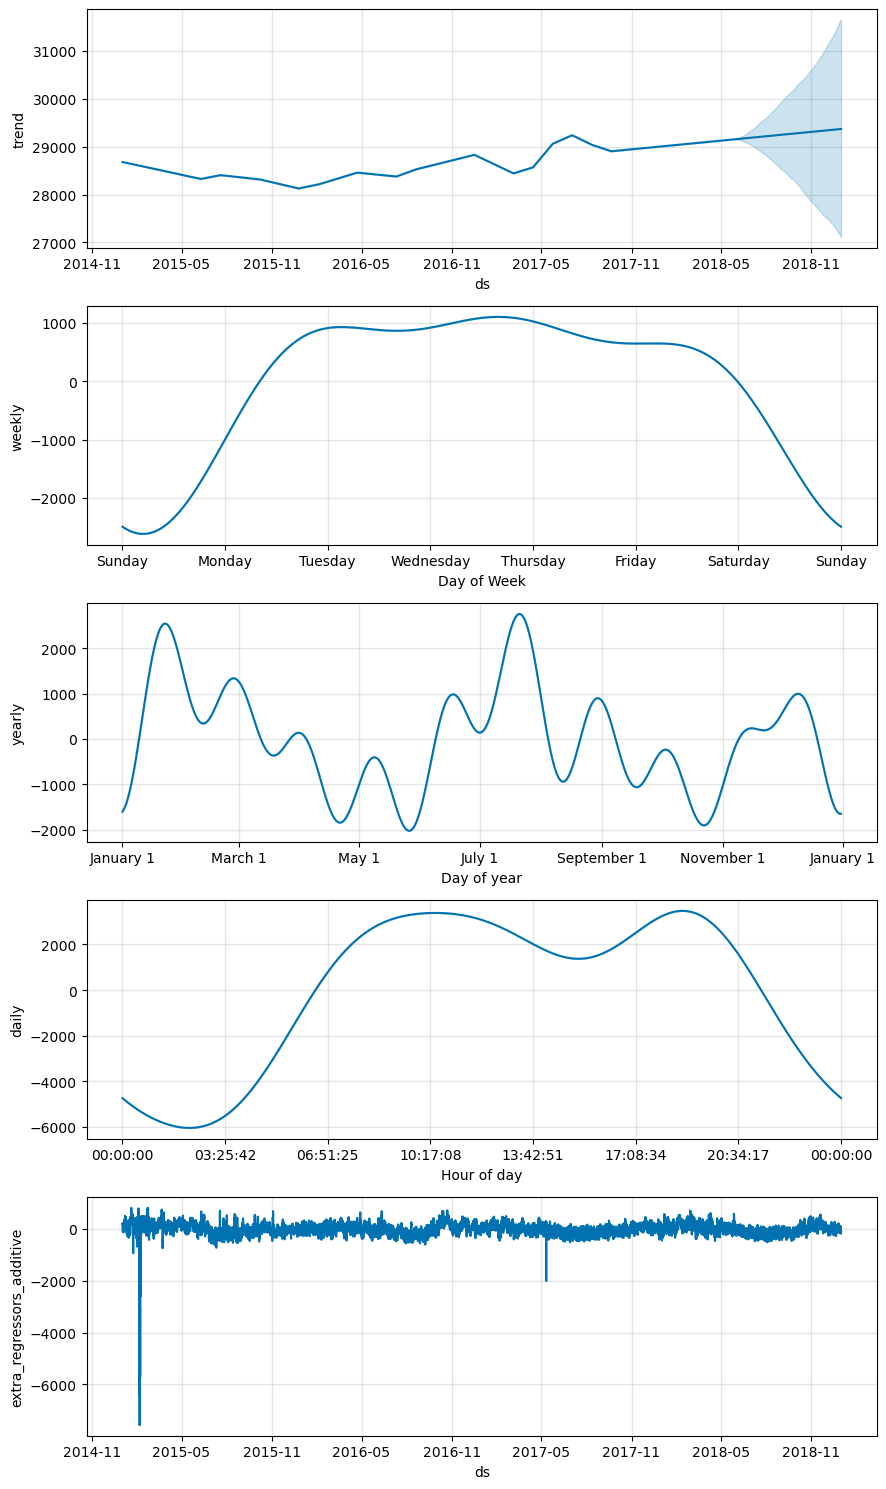

In [72]:
#plot the components of the results
_ = proph_mod.plot_components(forecast)

In [75]:
#calculate error metrics
error_metrics(y_true = trainP.append(testP)['y'], y_pred = forecast['yhat'], 
              model_name = "FB Prophet Using Auto-Seasonality and Weather Regressors")


Error metrics for model: FB Prophet Using Auto-Seasonality and Weather Regressors
RMSE: 2680.17
Variance/R^2: 0.66
MAE: 2014.23
Mean Absolute Percentage Error: 7.17 %


C:\Users\ehard\AppData\Local\Temp\ipykernel_19668\615374977.py:2: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  error_metrics(y_true = trainP.append(testP)['y'], y_pred = forecast['yhat'],


So far, FB Prophet performs the best on the long range, multi-month forecast of all the models tested.

C:\Users\ehard\AppData\Local\Temp\ipykernel_19668\4047725500.py:2: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  plot_ts_pred_true(y_pred = forecast.set_index('ds')['yhat'], y_true = trainP.append(testP).set_index('ds')['y'],


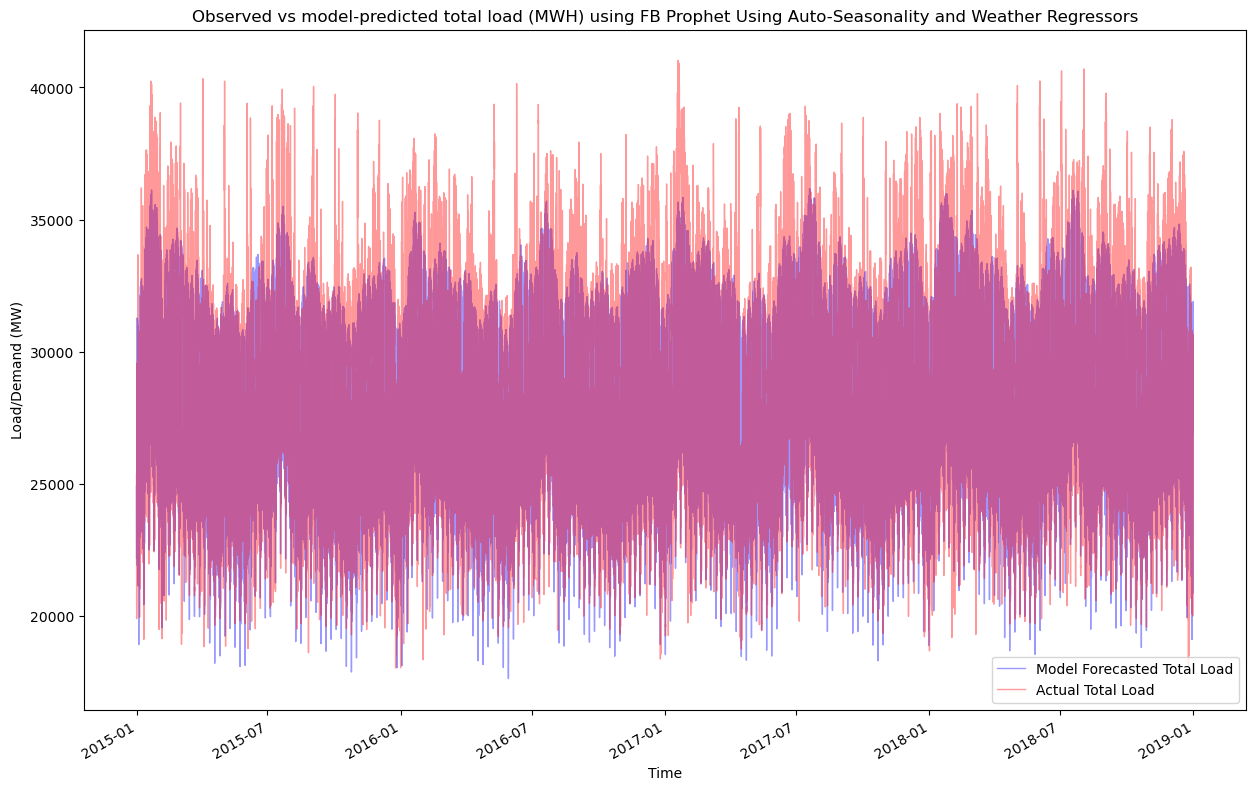

In [74]:
#
plot_ts_pred_true(y_pred = forecast.set_index('ds')['yhat'], y_true = trainP.append(testP).set_index('ds')['y'], 
                  model_name = "FB Prophet Using Auto-Seasonality and Weather Regressors")

## XGBoost

One other model to try would be Extreme Gradient Boosting (or XGBoost) which often provides better results than other ML algorithms. XGBoost can do a decent job with time series forecasting where there is seasonality but not much trend, as it cannot extrapolate. Luckily this dataset essentially has no trend.